In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
from scipy.spatial import Voronoi, ConvexHull
from ipywidgets import IntProgress
from IPython.display import display
import pandas as pd
import os 
import datetime

'''USER INPUT: Starting parameters'''
square = 10                      # Size of the surface to be generated (Will always be a n*n square)
no_col = 5                       # Initial number of colonies to be generated
col_r = 2                        # Colonies generated initially will have a radius of col_r
no_bac = 100                     # Initial number of bacteria in each colony
coat_N_range = (1, 15)           # Range of numbers of antibacterial coating to run simulation on. Thickness of coating determined by N.
n_food = 2000                    # Initial amount of food

'''USER INPUT: Evolution parameters'''
k_die_0 = 35                                   # For syn colonies, default = 27.5 else will never converge.
k_replicate = 5
k_move = 50
move_mean = 0.75                                 # Mean distance moved by a bacterium
move_sd = 0.2                                    # Standard deviation of distance moved
r_eat = 1                                        # Maximum distance to a piece of food in order to eat it
syn_col = True                                   # True: synergistic colonies; False: competitive colonies

'''USER INPUT: Display and system parameters'''
show_food = True
plot_show = True
plot_condense = True                             # False: Display plot for every step. True: Display first, last plots and plots at intervals of 200.
                                                 # Note: plot_condense must be true or save_info will not be activated, to prevent overuse of RAM.
max_step = 2000                                  # Specify maximum number of steps. (Determines wall time)
max_repeats = 10                                 # Specify number of times to try to get stdev < 0.2* mean t1/2
max_bac = 5000
save_info = True                                # Save bacteria and food positions at each snapshot if true
col_symbols = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O'] # Symbols used to differentiat bacteria in csv file. Last symbol used for food

'''Creation of global variables'''
bacteria_list = [[] for i in range(no_col)]      # List of lists (colonies) of Bacteria objects
plots = []                                       # List of fig, ax plots
step_no = 0                                      # Number of steps that have taken place
bac_count = []
terminate = False
coat_N = 3                                       # Number of anti-bacterial coating
coat_d = 2                                       # Anti-bacterial coating thickness
t_half = []
comb_no = 0                                      # Testing this N,d combination currently

'''Definition of classes and functions'''
class Bacteria():                                # Class to contain information for each bacterium
    def __init__(self, pos, zone):
        self.pos = pos
        self.zone = zone                         # Coating zone the bacterium is on. None if not on coating
        self.age = 1
        self.meal = 11                           # Number of steps since last meal
        self.neighbours = -1
        return
        
    def decision(self):                          # Choose an action for the bacterium
        k_die = k_die_0
        if self.meal <= 10:                      # If the bacterium ate in the last 10 steps, 
            k_die = 0                            # it cannot die
        elif self.neighbours > 0:
            k_die = k_die_0/self.neighbours
            
        ks = (k_die, k_replicate, k_move)
        bact_actions = ["Die", "Replicate", "Move"] 
        action_weights = [k/sum(ks) for k in ks]
        bact_choice = np.random.choice(bact_actions, p = action_weights)
        return bact_choice
    
    def replicate(self, col):                                                         # Create a new bacterium at the
        if self.pos[0] <= 5:
            shift_x = 0.01
        else: shift_x = -0.01
        
        #if self.pos[1] < 5:
        #    shift_y = 0.005
        #else: shift_y = -0.005
        bacteria_list[col].append(Bacteria([self.pos[0]+shift_x, self.pos[1]], self.zone))                      # same colony, position and zone
        return

    def move(self):  
        plus_minus = np.random.randint(2, size = 2)
        if plus_minus[0] == 1:
            x_new = self.pos[0] + np.random.normal(loc = move_mean, scale = move_sd)
        else: 
            x_new = self.pos[0] - np.random.normal(loc = move_mean, scale = move_sd)
        
        if plus_minus[1] == 1:
            y_new = self.pos[1] + np.random.normal(loc = move_mean, scale = move_sd)
        else:
            y_new = self.pos[1] - np.random.normal(loc = move_mean, scale = move_sd)
        
        if (x_new > square or y_new > square or x_new < 0 or y_new < 0):              # If new coords are out of bounds,
            return                                                                    # movement is rejected.
      
        if self.zone != None:                                                         # If the bacterium is on the coating,
            if (y_new < coat_zones[self.zone][0] or y_new > coat_zones[self.zone][1]):# and the movement brings it out, 
                return                                                                # movement is rejected.
            
        self.pos = [x_new, y_new]                                                 # Update the bacterium's position
        for i, zone in enumerate(coat_zones):                                     # Update the bacterium's zone
            if zone[0] < y_new < zone[1]:
                self.zone = i
                break 
        return

class SmallHull():                                  # Imitates hull object for colonies of size 1 or 2
    def __init__(self, points):
        self.points = np.asarray(points)
        if len(points) > 1:
            self.simplices = [(0,1)]
            self.vertices = np.array([0,1])
        else:
            self.simplices = []
            self.vertices = np.array([0])
    
def snapshot():                                    # Visualise the current state of the system
    global terminate
    total_bac = 0
    for col in bacteria_list:                      # Count the total number of bacteria still alive at this step
        total_bac += len(col)
    
    if total_bac < (no_col*no_bac)/2:
        terminate = True  
    
    if plot_condense and not terminate and step_no != 0 and (step_no +1) % 20 != 0:
        return total_bac
    
    if save_info:
        save_file(total_bac)
    
    if plot_show:
    
        gen_hulls()

        fig, ax = plt.subplots(figsize = (10,10))                                           # Set the axes parameters
        if terminate:
            ax.set_title('Step {0} (Final Step)'.format(step_no))
        else:
            ax.set_title('Step {0}'.format(step_no))
        ax.set_xlim(0, square)
        ax.set_ylim(0, square)
        ax.set_aspect('equal')

        for zone in coat_zones:                                                             # Plot the coating
            ax.fill_between((0,square), [zone[0]]*2, [zone[1]]*2, facecolor = (0,1,0,0.2))

        if show_food:                                                                       # Plot the food
            ax.scatter(food_array[:,0], food_array[:,1], marker = 'x')

        for col in bacteria_list:                                                           # Plot the bacteria
            pos_list = np.array([bac.pos for bac in col])
            ax.scatter(pos_list[:,0], pos_list[:,1])

        for hull in hulls:                                                                  # Plot the colony bounds
            if hull == 0:
                continue
            p = hull.points
            for line in hull.simplices:
                ax.plot([p[line[0],0], p[line[1],0]], [p[line[0],1], p[line[1],1]], c='r')

        plots.append((fig, ax))                                                             # Add the figure and axes
                                                                                            # to the plot list            
        plt.savefig(r"Data{5}/comb_{4}/N={2}_d={3}_Sim={0}_StepNo={1}.png".format(len(t_half[comb_no]), step_no, test_combs[comb_no, 0],  test_combs[comb_no, 1], comb_no, timestamp))
        plt.show()
    return total_bac                                                                              
    
def gen_coat():                                 # Generates the anti-bacterial coating
    global coat_zones
    
    N, d = coat_N, coat_d
    if N*d >= square:
        raise ValueError('N x d < square side')
    
    d2 = (square - N*d)/(N+1)                           # Calculate the width of non-coated regions
    lowers = np.arange(d+d2, square, d+d2)              # Calculate the list of lower edges of coated zones
    uppers = lowers-d                                   # Calculate the list of lower edges of coated zones
    coat_zones = np.column_stack((uppers, lowers))      # Stack the 2 lists as columns in an array,
    return                                              # Such that each row represents one zone.

def gen_col():                                  # Generates the bacteria for each colony

    col_centers = square*np.random.rand(no_col,2)       # Generate 5 random positions for the colony centres
    
    for i, center in enumerate(col_centers):            # For each colony centre,
        while len(bacteria_list[i]) < no_bac:           # loop until the colony has enough bacteria.
            r = np.random.triangular(0, col_r, col_r)   # Generate a random r limited by the colony radius,
            theta = np.random.rand()*2*np.pi            # generate a random angle theta,
            x = r*np.cos(theta) + center[0]             # then convert them to x and y,
            y = r*np.sin(theta) + center[1]             # translating wrt colony centre 
            if x<0 or x>square or y<0 or y>square:      # If the x, y exceeds the surface, generate a new pair
                continue 

            z = None
            for j, zone in enumerate(coat_zones):       # Check if the position falls in a coated zone
                if zone[0] < y < zone[1]:
                    z = j
                    break
                    
            bacteria_list[i].append(Bacteria([x, y], z))# Create a Bacteria object and add it to the bacteria list
    return

def count_neighbours():                              # Count the number of neighbours for each bacterium
    
    for one_col in bacteria_list:                                # For each colony,
        if len(one_col) == 1:
            one_col[0].neighbours = 0
        
        elif len(one_col) == 2:
            for bac in one_col:
                bac.neighbours = 1     
        
        else: 
            try:
                vor = Voronoi(np.array([bac.pos for bac in one_col]))    # construct a Voronoi object.
            except:
                continue
            for i, bac in enumerate(one_col):                        # For each bacterium in the colony,
                region_index = vor.point_region[i]                   # find the index of its cell, and
                bac.neighbours = len(vor.regions[region_index])      # update its neighbours attribute.
        
    return                                                       # (no. of edges of V cell = no. of neighbours)

def gen_food():                                     # Generate the food
    
    global food_array
    food_array = square*np.random.rand(n_food, 2)         # Generate random x, y coords in an array
    return

def lunchtime():                        # Each bacterium eats food if nearby
    global food_array
    
    for col in bacteria_list:                                        # For each bacterium,   
        for bac in col:                                              # Filter the food array for nearby food
            x, y = bac.pos
            food_near = food_array[np.logical_and.reduce((food_array[:,0] > x-r_eat, food_array[:,0] < x+r_eat, food_array[:,1] > y-r_eat, food_array[:,1] < y+r_eat)), :]
            if len(food_near) > 0:
                dists = [np.sqrt((fpos[0]-x)**2 + (fpos[1]-y)**2) for fpos in food_near]
                min_dist = min(dists)                                # Calculate distance to nearest food
            else:                                                    # If no food is nearby,
                continue                                             # move on to the next bacterium

            if min_dist <= r_eat:                                    # If nearest food is near enough,
                nearest = food_near[dists.index(min_dist)]
                uneaten = np.all(food_array != nearest, axis = 1)
                food_array = food_array[uneaten,:]                   # remove it from the food array, and
                bac.meal = 1                                         # update the bacterium's meal attribute.
    return

def get_overlap():                 # Check if two hull objects overlap
    
    overlap_list = []
    
    for i in range(len(hulls) -1):                         # Loop through all possible pairs of
        for j in range (i+1, len(hulls)):                  # overlapping colonies without repetition
            if hulls[i] == 0 or hulls[j] == 0:
                continue
                
            if (len(hulls[i].points) + len(hulls[j].points)) <= 3:
                overlap = False
                continue
            
            else: 
                overlap = True                           # Unless shown otherwise, the hulls overlap       
            orthos = []                                    # List to contain the edge normal vectors

            for hull in [hulls[i], hulls[j]]:
                p = hull.points
                for edge in hull.simplices:
                    evec = p[edge[1]] - p[edge[0]]         # Calculate vectors for each edge of each hull
                    orthos.append([-evec[1], evec[0]])     # Calculate edge normals

            for ortho in orthos:                                                   #for each edge normal,
                proj_lim = []
                for hull in [hulls[i], hulls[j]]:                                  #for each hull,
                    projs = [hull.points[v]@ortho for v in hull.vertices]          #project each vertex onto the normal
                    proj_lim += (min(projs), max(projs))                           #take the shortest and longest projections
                if not (proj_lim[2] < proj_lim[1] and proj_lim[3] > proj_lim[0]):  #if the projections do not overlap, 
                    overlap = False                                                #the colonies do not overlap
                    break
            
            if overlap:
                overlap_list.append({i,j})                   # append it to the overlap list.
    
    return overlap_list

def col_merge(ix_list):                            # Merges overlapping colonies  
    
    global bacteria_list
    new_bacteria_list = []
    all_cols = set(range(len(bacteria_list)))                         # Indices of all colonies (CHANGED)
    merging_cols = set().union(*ix_list)                              # Indices of colonies that will be merged
    
    while len(merging_cols) < len([j for i in ix_list for j in i]):   # While there are repeats in ix_list,
        for a, b in itr.combinations(ix_list, 2):                     # loop through each pair of overlaps
            if not a.isdisjoint(b):                                   # If two overlaps intersect,
                a.update(b)                                           # replace one with their union,
                ix_list.remove(b)                                     # delete the other,
                break                                                 # search for intersections again
    
    for group in ix_list:                                             # ix_list is now a list of
        new_col = []                                                  # non-intersecting sets
        for i in group:
            new_col += bacteria_list[i]                               # Join colonies to be merged
        new_bacteria_list.append(new_col)                             # and append them to a new list
    
    for nonmerging in all_cols.difference(merging_cols):
        new_bacteria_list.append(bacteria_list[nonmerging])           # Add the non-merging colonies into the list

    bacteria_list = new_bacteria_list
    return   

def col_fight(ix_list):                         # Overlapping colonies fight until they no longer overlap
    
    for ix in ix_list:
        fighting_cols = list(ix)
        if (len(bacteria_list[fighting_cols[0]]) == 0 or len(bacteria_list[fighting_cols[1]]) == 0): # Check for empty colony list
            continue
        champs = [np.random.choice(bacteria_list[col]) for col in fighting_cols]
        strengths = [10/champ.age + np.sqrt(len(bacteria_list[col])) + 10/champ.meal for champ, col in zip(champs, fighting_cols)]
        ps = [1-strength/sum(strengths) for strength in strengths]
        loser = np.random.choice([0,1], p = ps)
        bacteria_list[fighting_cols[loser]].remove(champs[loser])
    return

def bact_actions():                     # Choose and execute an action for each bacterium

    for i, col in enumerate(bacteria_list):  # For each colony,
        dying_bac = []
        reping_bac = []
        for j, bac in enumerate(col):        # for each bacterium,
            outcome = bac.decision()         # choose an action
            if outcome == 'Move':            # If move is chosen,
                bac.move()                   # call the move method
            elif outcome == 'Die':           # If die or replicate are chosen, 
                dying_bac.append(j)          # append them to lists to be executed after the loop
            elif outcome == 'Replicate':
                reping_bac.append(j)
            
        for index in reping_bac:
            col[index].replicate(i)          # Replicate bacteria who chose replicate
        
        for index in reversed(dying_bac):  
            del(col[index])                  # Delete bacteria who chose death, starting from the last in the list
    return

def gen_hulls():                             # Calculates the convex hulls for each colony
    global hulls
    hulls = []
    pos_list = [np.array([bac.pos for bac in col]) for col in bacteria_list]
    for pos in pos_list:

        if len(pos) > 2:
            try:
                hulls.append(ConvexHull(pos))
            except:
                hulls.append(0)
                pass
        else:
            hulls.append(SmallHull(pos))
    return

def col_interact():
    
    while [] in bacteria_list:
        bacteria_list.remove([])
    
    if len(bacteria_list) > 1:
        gen_hulls() 
        overlap_list = get_overlap()
        
        if len(overlap_list) > 0:                                    
            if syn_col:                                              # If colonies are synergistic,
                col_merge(overlap_list)                              # get them to merge

                
            else:                                                    # If colonies are competitive,
                while len(overlap_list) > 0:
                    col_fight(overlap_list)                          # Get them to fight, then
                    while [] in bacteria_list:
                        bacteria_list.remove([])

                    gen_hulls()                                      # generate new hulls, and
                    overlap_list = get_overlap()                     # check for overlaps again
    return 

def coat_N_d_list():
    global N_counts     # To determine the number of combinations for a given N. Used during interpolation to find min(t_half)
    
    N_min = coat_N_range[0]
    N_max = coat_N_range[1]
    
    delta_d = 0.01*sum([(10/N) for N in range(N_min, N_max)])   # Find delta d such that around 100 combinations can be obtained
    d_min = delta_d/2.5                                         # Choose a d_min such that after rounding, 100 or more
                                                                # combinations will always be obtained.
    test_combs = np.zeros((100, 2))
    
    d_list = []
    N_list = []
    N_counts = []
    for N_val in range(N_min, N_max):
        ds = list(np.arange(d_min, 10/N_val, delta_d))          # Populate the N and d_lists
        N_counts.append(len(ds))
        d_list += ds.copy()
        
        for i in ds:
            N_list.append(N_val)
    
    test_combs = np.zeros((100,2))
    test_combs[:, 0] = N_list[:100].copy()
    test_combs[:, 1] = np.round(d_list[:100].copy(), decimals = 3)
    return test_combs

def increment():                 # Makes time pass
    global step_no
    step_no += 1
    for col in bacteria_list:
        for bac in col:
            bac.age += 1
            bac.meal += 1
    return

def setup():                     # Sets up the surface, bacteria, food and AB coating
    global bac_count
    gen_coat()
    gen_food()
    gen_col()
    bac_count.append(snapshot())
    return

def save_file(total_bac):       # Writes the simulation state (position of food and bacteria) into a csv file 

    data_file = r"Data{5}/comb_{3}/N={1}_d={2}_Sim={0}_StepNo={4}.csv".format(len(t_half[comb_no]), test_combs[comb_no, 0],  test_combs[comb_no, 1], comb_no, step_no, timestamp)
    f = open(data_file, "a")    # To save various headers 
    f.write("\n %s %s %s %s %s %s \n" % ("Sim No:,", "{0},,".format(len(t_half[comb_no])), "N:,", "{0},,".format(test_combs[comb_no, 0]), "d:,", "{0}".format(test_combs[comb_no, 1])))
    f.write("%s %s %s %s %s \n \n" % ("Step No:,", "{0},,".format(step_no), "N_bact:,", "{0},,".format(total_bac), "N_food:,{0}".format(len(food_array))))
    f.write("%s %s %s \n" % ("Symbol:,", "pos x:,", "pos y:"))
    f.close()
    
    pos_list = [[bac.pos for bac in col] for col in bacteria_list]
    bac_output = np.zeros((total_bac, 3), dtype = "<U4")
    food_output = np.zeros((len(food_array), 3), dtype = '<U4')
    
    temp_counter = 0
    for i, col in enumerate(bacteria_list):
        for bac in col:
            bac_output[temp_counter] = [col_symbols[i], str(bac.pos[0]), str(bac.pos[1])] # Diff colonies have diff symbols
            temp_counter += 1
    
    for j, food_pos in enumerate(food_array):
        food_output[j] = [col_symbols[-1], str(food_pos[0]), str(food_pos[1])]    # Food symbol given as last symbol
    
    f = open(data_file, "a")
    np.savetxt(f, bac_output, delimiter = ',', fmt='%s')       # To save position of each bacteria
    np.savetxt(f, food_output, delimiter = ',', fmt = '%s')    # To save position of each food
    f.close()

    return

def step():               # Contains events that happen at each evolution step
    global bac_count    
    increment()
    count_neighbours()
    bact_actions()
    lunchtime()
    col_interact()
    bac_count.append(snapshot())
    return

def one_sim(N, d, j):    # Runs the simulation step() function. Also shows the progress of the simulation as a bar
    global coat_N        
    global coat_d
    global step_no
    
    coat_N = int(N)
    coat_d = d    
    setup()
    f = IntProgress(min=0, max=max_step, description="Sim {0}:".format(j)) 
    display(f)            # instantiate progress bar
    for i in range(max_step):
        f.value += 1
        if terminate:
            f.value = max_step
            f.bar_style = 'success'
            break

        step()
        if (bac_count[-1] > max_bac):
            f.value = max_step
            f.bar_style = 'warning'
            step_no = -1
            print("The simulation cannot support more than {0} bacteria (Total).".format(max_bac))
            break
    
    if step_no >= max_step and not terminate:
        f.bar_style = 'warning'
        step_no = -1
        print("Terminating this simulation before t1/2 was found. If t1/2 exists, it is > {0}".format(max_step))

    return step_no

def find_thalf(i):         # Perform two or more simulations for a particular N, d pair
    global bacteria_list   # terminates if a good stdev is achieved or after max_repeats tries
    global plots
    global terminate
    global step_no
    
    for j in range (max_repeats):          # Try a fixed number of times to get std_dev of t_1/2 to be < 0.2 mean t_1/2

        bacteria_list.clear()                        # Reset all global variables before each simulation
        bacteria_list = [[] for m in range(no_col)]      
        plots.clear()                                    
        step_no = 0                                     
        bac_count.clear()
        terminate = False
        t_half[i].append(one_sim(test_combs[i, 0], test_combs[i, 1], j))   # Carry out the first simulation
        if len(t_half[i]) > 1:                                             # Break if more than 1 sim and stdev = 0.2*mean 
            remove_minusone = np.extract([k != -1 for k in t_half[i]], t_half[i])
            if np.std(remove_minusone) < 0.2*np.mean(remove_minusone) and len(remove_minusone) > 1:
                column = ['Sim {0}'.format(j) for j in range(len(t_half[i]))]
                t_half[i].append(np.std(remove_minusone))
                t_half[i].append(np.mean(remove_minusone))
                column.append("Stdev")
                column.append("Mean")
                print(pd.DataFrame([column, t_half[i]]))                   # To format data neatly into a table
                return
    
    print("Note: Could not find t1/2 to be within 0.2*mean after the stipulated tries.") # If after max_repeat iterations the condition
    column = ['Sim {0}'.format(j) for j in range(len(t_half[i]))]                        # of stdev = 0.2*mean cannot be fulfilled
    remove_minusone = np.extract([k != -1 for k in t_half[i]], t_half[i])
    t_half[i].append(np.std(remove_minusone))
    t_half[i].append(np.mean(remove_minusone))
    column.append("Stdev")
    column.append("Mean")
    print(pd.DataFrame([column, t_half[i]]))
    
'''Simulation time'''
test_combs = coat_N_d_list()
timestamp = " " + str(datetime.datetime.now())[-15:-13] + str(datetime.datetime.now())[-12:-10]

if save_info or plot_show:
    try:                            
        os.mkdir(r"Data{0}".format(timestamp))
    except:
        pass

for i in range(100):               # For each combination, try to find thalf such that stdev < 0.2*mean thalf
    
    if save_info or plot_show:
        try: 
            os.mkdir(r"Data{1}/comb_{0}".format(i, timestamp))
        except:
            pass
    print('\n'+"Combination {0} (For N = {1}, d = {2}):".format(i + 1, test_combs[i, 0], test_combs[i, 1]))
    comb_no = i
    t_half.append([])
    find_thalf(i)





Combination 1 (For N = 1.0, d = 0.13):


<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 0:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 1:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

       0      1      2     3
0  Sim 0  Sim 1  Stdev  Mean
1     81     69      6    75

Combination 2 (For N = 1.0, d = 0.455):


<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 0:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 1:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

       0      1      2     3
0  Sim 0  Sim 1  Stdev  Mean
1     80     71    4.5  75.5

Combination 3 (For N = 1.0, d = 0.78):


<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 0:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 1:', max=2000)

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

       0      1      2     3
0  Sim 0  Sim 1  Stdev  Mean
1     80     95    7.5  87.5

Combination 4 (For N = 1.0, d = 1.106):


<Figure size 1000x1000 with 1 Axes>

IntProgress(value=0, description='Sim 0:', max=2000)

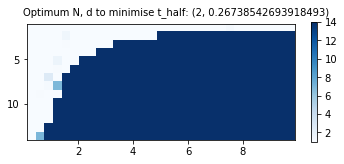

In [3]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d

N_list = test_combs[:, 0]
N_min, N_max = int(np.min(N_list)), int(np.max(N_list))
N_shape = N_max - N_min + 1
N_axis = [i for i in range(N_min, N_max + 1)]

d_list = test_combs[:, 1]
delta_d = 0.01*sum([(10/N) for N in range(coat_N_range[0], coat_N_range[1])])  # Find delta d such that around 100 combinations can be obtained
d_min, d_max = np.min(d_list), np.max(d_list)                                  # Choose a d_min such that after rounding, 100 or more
d_shape = int((d_max - d_min)/delta_d + 1)                                     # combinations will always be obtained.
d_axis = np.linspace(d_min, d_max, d_shape)                                    # Calculate the valid ds for the  N

heatmap = np.zeros((N_shape, d_shape))
zs = [i[-1] for i in t_half]
heatmap.fill(2*max(zs))                   # Set a high value for the invalid N, d values

for i, z in enumerate(zs):                # Fill the valid N, d values with the calculated t_half
    heatmap[int(N_list[i] - 1), int(np.round((d_list[i] - d_min)/delta_d))] = z

fig, ax =  plt.subplots()
plt.imshow(heatmap, cmap=plt.get_cmap('Blues'), extent=[d_min,d_max,N_max, N_min]
          , aspect = delta_d, interpolation = None)

plt.colorbar(shrink = 0.55)

split_indices = [sum(N_counts[0:i+1]) for i in range(len(N_counts)-1)]  
mean_t_split = np.split(zs, split_indices)                                     # group t-half values by their N value
d_split = np.split(test_combs[:, 1].copy(), split_indices)                     # group d-values by their N value
result = []

for i, (x, y) in enumerate(zip(d_split, mean_t_split)):
    
    if len(x)> 3:
        t_fun_d = interp1d(x, y, kind = 'cubic')                                                   # for each N, interpolate t_half wrt to d
        res = minimize(t_fun_d, x[np.argmin(y)], bounds = ((min(x), max(x)),) , method='SLSQP')    # find the d value which gives the minimum t_half
        result.append((i+1, res.x[0]))
        
    else:
        result.append((i+1, x[np.argmin(y)]))

index = result[:][1].index(min(result[:][1]))                                         # get the N value which has the global minimum t-half
plt.text(0, 0, "Optimum N, d to minimise t_half: {0}".format(result[index]))

plt.savefig(r"Data{0}/InterpolationResults.png".format(timestamp))
plt.show()
